## H2: Particle filter for a linear Gaussian state-space model

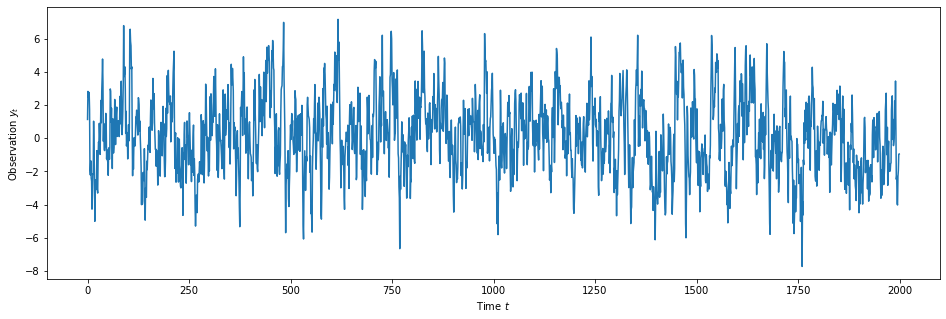

In [33]:
import os
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

def generate_data(T):
    y = np.zeros(T)
    x = np.zeros(T+1)
    x[0] = np.random.normal(loc=0.0, scale=np.sqrt(2.0) )
    for t in range(T):
        x[t+1] = np.random.normal(loc=0.8*x[t], scale=np.sqrt(0.5))
        y[t] = np.random.normal(loc=2*x[t+1], scale=np.sqrt(0.1))
    return y, x

np.random.seed(42)
T=2000
y, x = generate_data(T)

fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(y)
ax.set_xlabel("Time $t$"); ax.set_ylabel("Observation $y_t$");
plt.show()

In [34]:
# Implement the Kalman filter!
def kalman_filter(y, A, C, Q, R, P0):
    
    T = len(y)
    # Define filtering means x_hat and covariances P_hat
    x_hat = np.zeros(T+1)
    P_hat = np.zeros(T+1)
    
    # Initialize mean and cov at time 0 as zero and P0 respectively
    P_hat[0] = P0
    
    for t in range(1, T+1):
        
        P_time_update = A**2 * P_hat[t-1] + Q
        K = P_time_update * C / (P_time_update * C**2 + R)
        
        x_hat[t] = A*x_hat[t-1] + K*(y[t-1] - C*A*x_hat[t-1])
        P_hat[t] = P_time_update - K*C*P_time_update
        
    return x_hat, P_hat

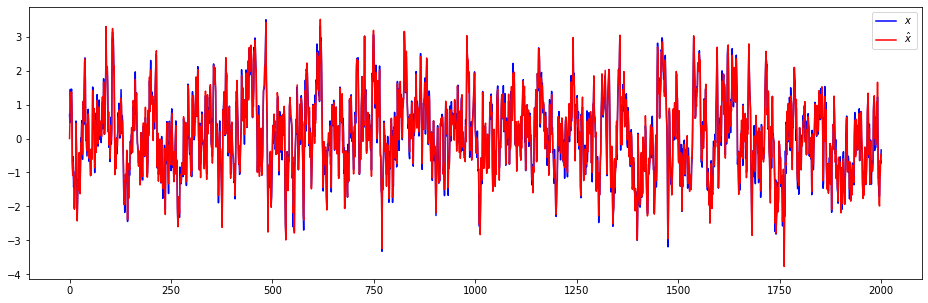

In [35]:
x_hat, P_hat = kalman_filter(y, A=0.8, C=2.0, Q=0.5, R=0.1, P0=2.0)

fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(x, 'b-', label='$x$', fillstyle='none')
ax.plot(x_hat, 'r-', label='$\hat{x}$', fillstyle='none')
#ax.set_xlim(-1, T+1)
ax.legend()
plt.show()

In [38]:
# Bootstrap particle filter
#def bootstrap_particle_filter(y, n_particles, resampling_type='multinomial', ess_thres=None):
def bootstrap_particle_filter(y, N, theta, resampling_type='multinomial'):

    # Static parameters 
    A = theta[0] # for mean of transition model
    C = theta[1] # for mean of observations
    Q = theta[2] # variance of process noise
    R = theta[3] # variance of observations
    
    # Initialization
    T = len(y)
    x = np.zeros([T+1, N])
    w = np.zeros([T+1, N])
    ancestors = np.zeros([T+1, N], dtype=int)
    
    x[0, :] = np.random.normal(0.0, 1.0, size=N)
    w[0, :] = np.ones(N) / N
    ancestors[0, :] = range(N)
    
    for t in range(1, T+1):
        
        if resampling_type == 'multinomial':
            ancestors[t, :] = multinomial_resampling(w[t-1, :])
        else:
            ancestors[t, :] = np.choice(N, N, p=w[t-1, :])
        
        x[t, :] = np.random.normal(loc=A*x[t-1, ancestors[t, :]], scale=np.sqrt(Q) )
        log_w_tilde = norm.logpdf(y[t-1], loc=C*x[t, :], scale=np.sqrt(R) )
                                  
        # Normalize with log trick
        max_w_tilde = np.max(log_w_tilde)
        log_w_tilde = log_w_tilde - max_w_tilde
        w_bar = np.exp(log_w_tilde - np.max(log_w_tilde))
        w[t, :] = w_bar / np.sum(w_bar)
    return x, w, ancestors

def multinomial_resampling(w):
    N = len(w)
    # Generate ordered uniform random numbers 
    u_sample = np.random.uniform(size=N)
    u = np.zeros(N)
    u[N-1] = u_sample[N-1]**(1/N)
    for k in range(N-1, 0, -1):
        u[k-1] = u[k] * u_sample[k-1]**(1/k) 
    
    # Generate offsprings
    ancestors = np.zeros(N, dtype=int)
    i = 0
    j = 0
    w_sum = 0.0
    while j < N:
        w_sum += w[i]
        while j < N and w_sum > u[j]:
            ancestors[j] = i
            j += 1
        i += 1 
    return ancestors

In [69]:
# Parameters 
A=0.8; C=2.0; Q=0.5; R=0.1; P0=2.0
# Run Kalman filter
means_kf, cov_kf = kalman_filter(y, A, C, Q, R, P0)
# Run bootstrap particle filter
theta = [A, C, Q, R]
N = 5000
x_bpf, w_bpf, ancestors = bootstrap_particle_filter(y, N, theta, resampling_type='multinomial')

In [70]:
# Compute BPF mean and variance
# See Eq. 13 in http://user.it.uu.se/~thosc112/pubpdf/schongk2011.pdf
means_bpf = np.sum(x_bpf * w_bpf, axis=-1)
cov_bpf = np.sum( (x_bpf - means_bpf[:,None])**2 * w_bpf, axis=-1)
adiff = np.mean(np.abs(means_kf - means_bpf))
print("Average absolute difference: ", adiff)

Average absolute difference:  0.0033400526818363717


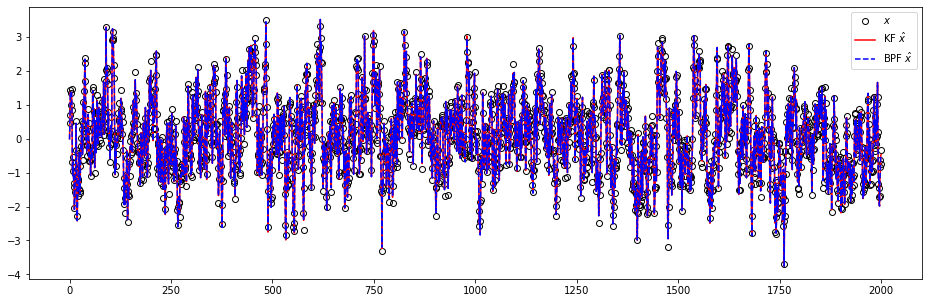

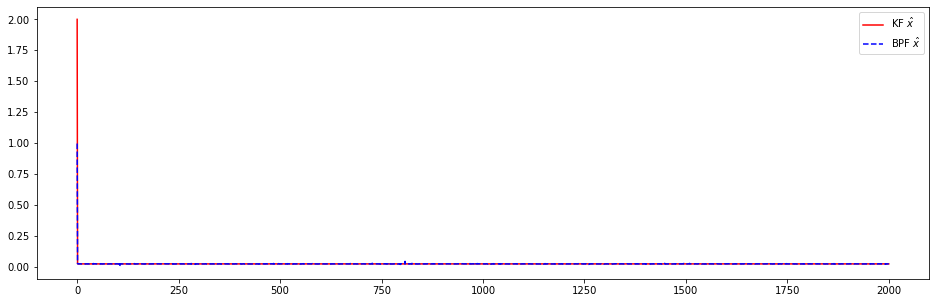

In [71]:
fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(x, 'ko', label='$x$', fillstyle='none')
ax.plot(means_kf, 'r-', label='KF $\hat{x}$')
ax.plot(means_bpf, 'b--', label='BPF $\hat{x}$')
ax.legend()

fig, ax = plt.subplots(figsize=(16, 5))
#ax.plot(x, 'ko', label='$x$', fillstyle='none')
ax.plot(cov_kf, 'r-', label='KF $\hat{x}$')
ax.plot(cov_bpf, 'b--', label='BPF $\hat{x}$')
ax.legend()
plt.show()